# Market Risk project

FOURREAU Mathis

GAUSSIN Natacha

ESILV IF3

# Library and dataset importation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv("Natixis.csv", sep = ";")

# Transform the date column to datetime and sort the dataframe by date
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y")
df.sort_values("date", inplace = True)

# Transform the value column to numeric
df["value"] = (df["value"].astype(str).str.replace(",", ".", regex=False))
df["value"] = pd.to_numeric(df["value"], errors="coerce")

# display the dataframe
df

,date,value
0,2015-01-02,5.621
1,2015-01-05,5.424
2,2015-01-06,5.329
3,2015-01-07,5.224
4,2015-01-08,5.453
...,...,...
1018,2018-12-21,4.045
1019,2018-12-24,4.010
1020,2018-12-27,3.938
1021,2018-12-28,4.088


In [3]:
# Compute the returns

df["return"] = df["value"] / df["value"].shift(1) - 1

# QUESTION : EST CE QUE LES RETURNS SONT BONS ICI CAR LES VARIATIONS DE TEMPS NE SONT PAS CONSTANTES ??

## Question A (Ex2, part of Q1 and of Q2 of TD1)

**a** – From the time series of the daily prices of the stock Natixis between January 2015 and December 2016, provided with TD1, estimate a historical VaR on price returns at a one-day horizon for a given probability level (this probability is a parameter which must be changed easily). You must base your VaR on a non-parametric distribution (biweight Kernel, that is $K$ is the derivative of the logistic function $x \mapsto \frac{15}{16}(1-x^2)^2 \mathbb{1}_{|x| \leq 1}$).

In [4]:
alpha = 0.01

In [5]:
# Extract returns for the years prior to 2017 (2015 and 2016)

returns_2015_2016 = df[df["date"] < "2017"].dropna().loc[:, "return"]

returns_2015_2016

1     -0.035047
2     -0.017515
3     -0.019704
4      0.043836
5     -0.020723
         ...   
508   -0.008118
509    0.000744
510   -0.000186
511   -0.009481
512    0.006006
Name: return, Length: 512, dtype: float64

### Estimation of the kernel density 
$$\hat{f}(x) = \frac{1}{nh}\sum_{i=1}^{n} K\left(\frac{x - X_i}{h}\right)$$ with $$K(x) = \frac{15}{16}(1-x^2)^2 \mathbb{1}_{|x| \leq 1}$$

The following functions are used to generate the kernel density for a wide range of x. This will be usefull to choose the value of h.

In [6]:
#def K(x)
def K(x):
    K_tab = []
    for i in x:
        if i <= 1 and i >= -1:
            K_tab.append((15/16) * (1 - i**2)**2)
        else:
            K_tab.append(0)
    return K_tab

# def f_hat(x, h, tab_returns)
def f_hat(x, h, tab_returns):
    return sum(K((x - tab_returns) / h)) / (len(tab_returns) * h)

# estimate 1000 times f_hat
def estimate_f_hat(tab_returns, h, nb_estimations = 1000):
    x_tab = np.linspace(min(tab_returns) - 5*h, max(tab_returns) + 5*h, nb_estimations)
    f_hat_tab = []
    for x in x_tab:
        f_hat_tab.append(f_hat(x, h, tab_returns))

    return f_hat_tab, x_tab

### Choice of h

Choosing the right value for the bandwidth is crucial to compute the Value at Risk. From different research papers, the following rules allow to calculate it.

**Scott’s rule**
$$
h_{\text{Scott}} = \sigma\, n^{-1/5}
$$

**Silverman’s rule**
$$
h_{\text{Silverman}} = 0.9\, \min\!\left(\sigma,\; \frac{\mathrm{IQR}}{1.34}\right) n^{-1/5}
$$

In [7]:
def ComputeHScott(tab_returns):
    return np.std(tab_returns) * np.power(len(tab_returns), -1/5)

def IQR(tab_returns):
    return tab_returns.quantile(0.75) - tab_returns.quantile(0.25)

def ComputeHSilverman(tab_returns):
    return 0.9 * min(np.std(tab_returns), IQR(tab_returns)/1.34) * np.power(len(tab_returns), -1/5)

h_scott = round(ComputeHScott(returns_2015_2016), 6)
h_silverman = round(ComputeHSilverman(returns_2015_2016), 6)
print("H computed with Scott's rule", h_scott)
print("H computed with Silverman's rule", h_silverman)

H computed with Scott's rule 0.006853
H computed with Silverman's rule 0.005443


The bandwidth value must be chosen so that the kernel density of price returns must display a good ratio between smoothness and noise. To do so, each kernel density is displayed.

**Representation of the kernel densities**

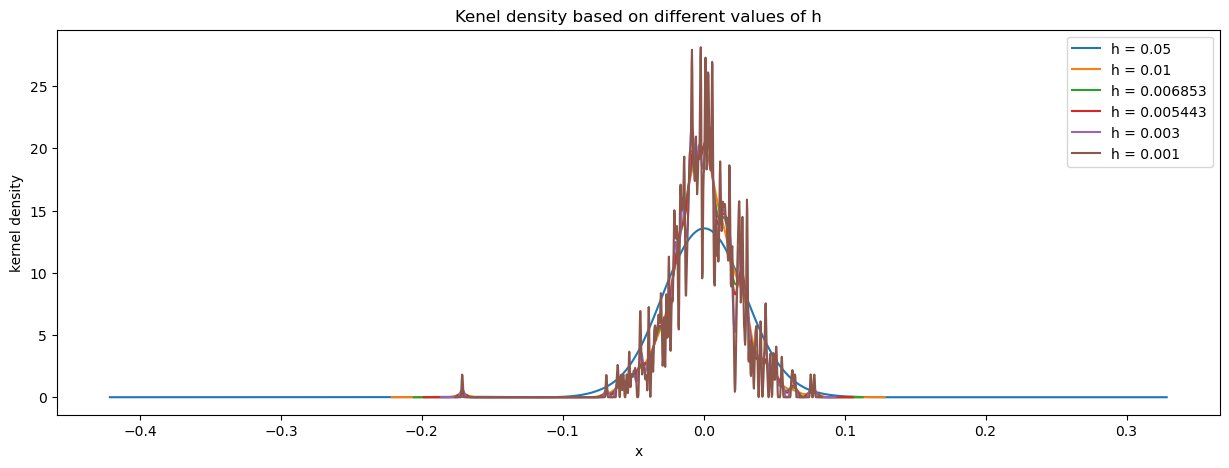

In [8]:
h_tab = [0.05, 0.01, h_scott, h_silverman, 0.003, 0.001]

plt.figure(figsize=(15, 5))
for h in h_tab:
    f_hat_tab, x_tab = estimate_f_hat(returns_2015_2016, h)
    plt.plot(x_tab, f_hat_tab, label = f"h = {h}")

plt.xlabel("x")
plt.ylabel("kernel density")
plt.title("Kenel density based on different values of h")
plt.legend()
plt.show()

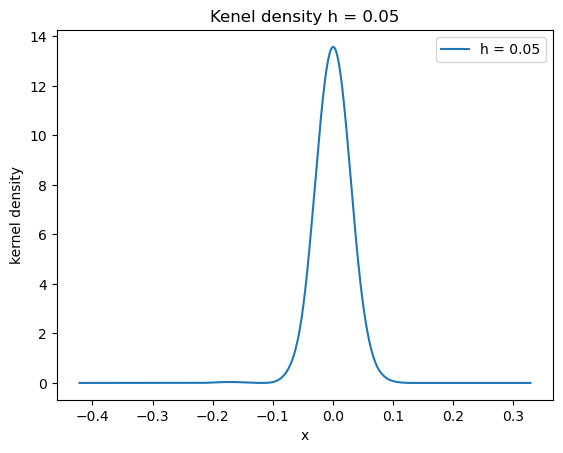

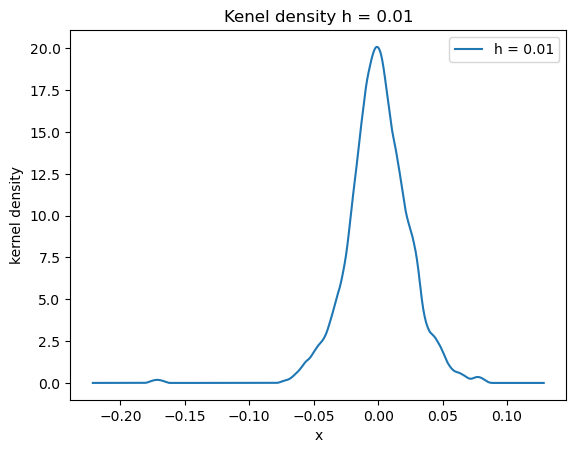

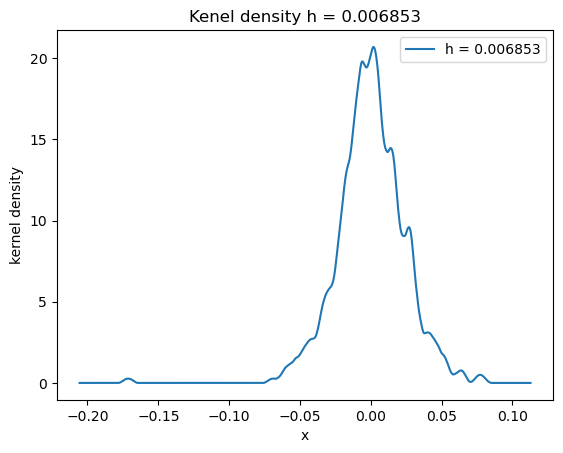

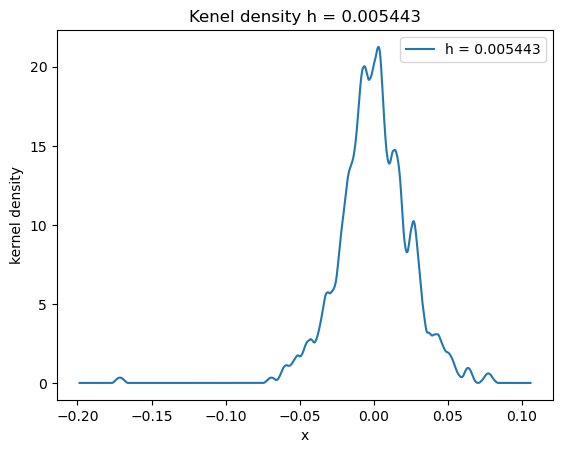

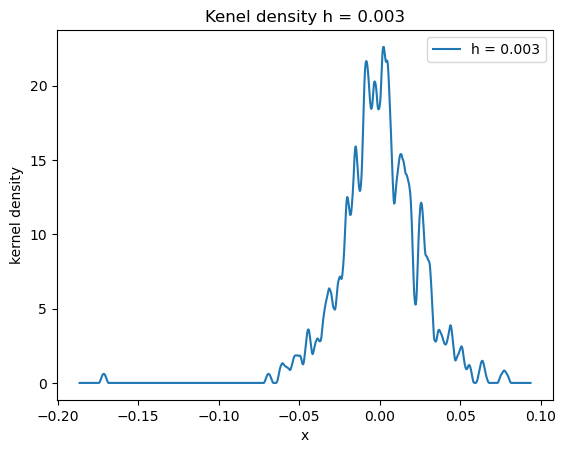

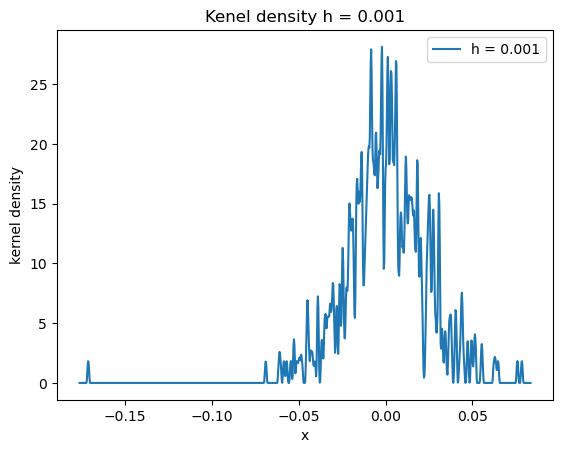

In [9]:
for h in h_tab:
    f_hat_tab, x_tab = estimate_f_hat(returns_2015_2016, h)
    plt.plot(x_tab, f_hat_tab, label = f"h = {h}")
    plt.xlabel("x")
    plt.ylabel("kernel density")
    plt.title(f"Kenel density h = {h}")
    plt.legend()
    plt.show()

**Observations**

From these graphs, we observe that the kernel density with h = 0.001 is very noisy. On the contrary, for higher h, the kernel density is too smooth leading to loss of information.
Some values of h seem to display a good ratio between noise and smoothness : h = 0.003, h = 0.005443 (Silverman’s rule) and h = 0.006853 (Scott’s rule).

Thus, we chose to continue the study with those three h

In [10]:
# we study those h
h_test = [0.003, h_silverman, h_scott]

### Define the CDF of K and f_hat

$$\hat{F}(x) = \frac{1}{n}\sum_{i=1}^{n} \mathcal{K}\left(\frac{x - X_i}{h}\right)$$

To define $\mathcal{K}$ we have to primitive K.

$$
\mathcal{K}(u) = \begin{cases}
0 & \text{si } u < -1 \\[0.5em]
\frac{15}{16}\left(u - \frac{2u^3}{3} + \frac{u^5}{5}+ \frac{8}{15}\right ) & \text{si } -1 \leq u \leq 1 \\[0.5em]
1 & \text{si } u > 1
\end{cases}
$$


To compute the Value at risk for small values of $\alpha$ (values close to 0), we use the convention given in the course :

$$
\mathrm{VaR}_{\alpha}(X) = -F_X^{-1}(\alpha)
$$


In [11]:
def K_cdf(x):
    if x <= 1 and x >= -1:
        return (15/16)*(x - 2*(x**3)/3 + (x**5)/5 + 8/15)
    elif x < -1:
        return 0.0
    else:
        return 1.0

def K_cdf_vector(u_tab):
    return [K_cdf(u) for u in u_tab]

def F_hat(x, h, returns_tab):
    u_tab = (x-returns_tab)/h
    return sum(K_cdf_vector(u_tab)) / len(returns_tab)

def Series_F_Hat(h, returns_tab, x_tab):
    return [F_hat(x, h, returns_tab) for x in x_tab]

Let's check the distribution of the cdf :

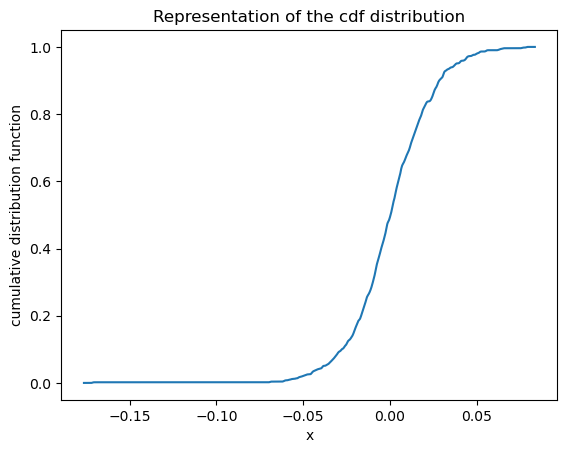

In [12]:
x_tab = np.linspace(min(returns_2015_2016) - 5*h, max(returns_2015_2016) + 5*h, 1000)
F_hat_tab = Series_F_Hat(h, returns_2015_2016, x_tab)
plt.plot(x_tab, F_hat_tab)
plt.xlabel("x")
plt.ylabel("cumulative distribution function")
plt.title("Representation of the cdf distribution")
plt.show()

### Compute the VaR and apply backtesting

In [13]:
def ComputeVaR(returns_tab, alpha, h, nb_estimations=1000):
    x_tab = np.linspace(min(returns_tab) - 5*h, max(returns_tab) + 5*h, nb_estimations)
    F_hat_tab = Series_F_Hat(h, returns_tab, x_tab)
    i = 0
    while i < len(F_hat_tab):
        if F_hat_tab[i] >= alpha:
            return - x_tab[i]
        i+=1

    return - x_tab[len(x_tab) - 1]

def ComputeMultipleHVaR(returns_tab, alpha, h_tab):
    dico_var = {}
    for h in h_tab:
        dico_var[h] = ComputeVaR(returns_tab, alpha, h)
    return dico_var

In [14]:
dico_var = ComputeMultipleHVaR(returns_2015_2016, alpha, h_test)

for key, value in dico_var.items():
    print(f"for h = {key}, VaR = {round(value, 6)} with alpha = {alpha}")

for h = 0.003, VaR = 0.057508 with alpha = 0.01
for h = 0.005443, VaR = 0.057256 with alpha = 0.01
for h = 0.006853, VaR = 0.057439 with alpha = 0.01


**Observations**

The Value at Risk for a fixed alpha changes with respect to the value of the bandwidth h. Moreover, there is no clear relationships between h and VaR as h affects the whole density distribution. 

In addition, we observe that the value at risk only varies a little based on h. This is due to the choice of the studied bandwidths (their values are close).

In [15]:
def Proportion(df, VaR):
    return df[df < -VaR].count() / df.count()

VaR_Silverman = dico_var[h_silverman]

print(f"For Silverman value at Risk, the proportion of returns that exceeds the VaR threshold is {Proportion(returns_2015_2016, VaR_Silverman)}")

For Silverman value at Risk, the proportion of returns that exceeds the VaR threshold is 0.009765625


The proportion of values that exceed the Value at Risk is approximately equal to $\alpha$ meaning that the VaR is consistent with the confidence level.

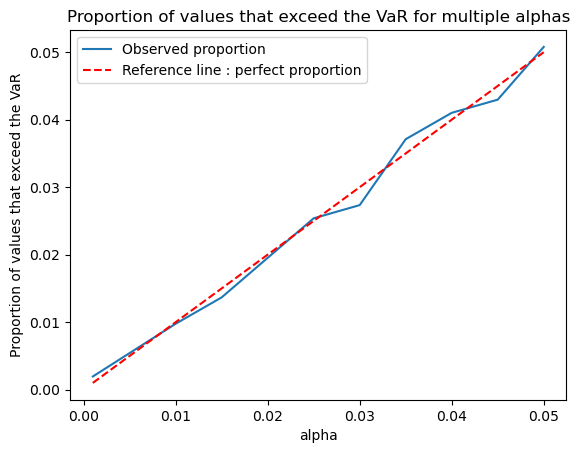

In [16]:
# Coverage
alpha_tab = [0.001, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
proportion_tab = []
for a in alpha_tab:
    proportion_tab.append(Proportion(returns_2015_2016, ComputeVaR(returns_2015_2016, a, h_silverman)))

plt.plot(alpha_tab, proportion_tab, label = "Observed proportion")
plt.plot(alpha_tab, alpha_tab, color = "r", linestyle = "--", label = "Reference line : perfect proportion")
plt.xlabel("alpha")
plt.ylabel("Proportion of values that exceed the VaR")
plt.title("Proportion of values that exceed the VaR for multiple alphas")
plt.legend()
plt.show()

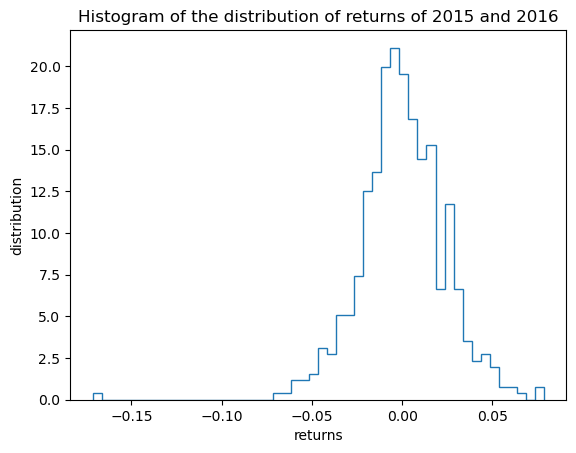

In [17]:
# Independency

plt.hist(returns_2015_2016, bins=50, density=True, label="2015-2016", histtype="step", stacked=True, fill = False)
plt.xlabel("returns")
plt.ylabel("distribution")
plt.title("Histogram of the distribution of returns of 2015 and 2016")
plt.show()

Only one value that exceed the VaR, so the independency is validated.

**Choice of the VaR based on h**

To choose the best bandwidth applied to our senario, we studied different research papers. The Silverman's rule focus on the density function global shape and cope with non-normal desities. In addition, when the data is unimodal and not symmetric, the silverman's rule well performs. In our case, the density verifies these conditions. Indeed, the histogram shows that the data is unimodal meaning that the distribution operates in one regime (the density has one peak and the data is mostly gathered into one cluster), the density in also non-symmetric and non-normal.

References :
"THE OPTIMAL BANDWIDTH FOR KERNEL DENSITY ESTIMATION OF SKEWED DISTRIBUTION: A CASE STUDY ON SURVIVAL TIME DATA OF CANCER PATIENTS", written by Netti Herawati, Khoirin Nisa, Eri Setiawan
http://repository.lppm.unila.ac.id/7532/1/The%20Optimal%20Bandwidth%20For%20Kernel%20Density%20Estimation%20Of%20Skewed%20Distribution%20A%20Case%20Study%20On%20Survival%20Time%20Data%20Of%20Cancer%20Patients.pdf

"How Bandwidth Selection Algorithms Impact Exploratory Data Analysis Using Kernel Density Estimation", written by Jared K. Harpole
https://files01.core.ac.uk/download/pdf/213401766.pdf

**Let's verify the conditions where Silverman's rule is efficient**

On the histogram we see that there is only one visible peak and clearly not symmetric.

**Conclusion on the VaR**

To conclude, we chose the bandwidth computed with the Silverman's rule : h = 0.005443.

**The chosen variables thus are :**

In [18]:
h = 0.005443
VaR = dico_var[h]

print(f"VaR : {VaR} with h = {h}")

VaR : 0.05725640068251581 with h = 0.005443


**b – Which proportion of price returns between January 2017 and December 2018 does exceed the VaR
threshold defined in the previous question? Do you validate the choice of this non-parametric VaR?**


In [19]:
returns_2017_2018 = df[df["date"] >= "2017"].dropna().loc[:, "return"]
returns_2017_2018

513     0.007463
514     0.040741
515     0.003737
516    -0.008155
517    -0.005719
          ...   
1018   -0.001481
1019   -0.008653
1020   -0.017955
1021    0.038090
1022    0.007583
Name: return, Length: 510, dtype: float64

In [20]:
def VaREstimation(prop, alpha):
    if prop > alpha:
        print("VaR underestimates the risk")
    elif prop == alpha:
        print("VaR is correct")
    else:
        print("VaR overestimates the risk")

def MultipleVaRProportion(returns_tab, dico_var, alpha):
    for key, value in dico_var.items():
        prop = Proportion(returns_tab, value)
        print(f"for h = {key}, for VaR = {value} we have:")
        print("the proportion of returns that exceed the VaR threshold is", round(prop, 6))
        VaREstimation(prop, alpha)
        print()

MultipleVaRProportion(returns_2017_2018, dico_var, alpha)

for h = 0.003, for VaR = 0.05750841439123988 we have:
the proportion of returns that exceed the VaR threshold is 0.001961
VaR overestimates the risk

for h = 0.005443, for VaR = 0.05725640068251581 we have:
the proportion of returns that exceed the VaR threshold is 0.001961
VaR overestimates the risk

for h = 0.006853, for VaR = 0.05743884645453401 we have:
the proportion of returns that exceed the VaR threshold is 0.001961
VaR overestimates the risk



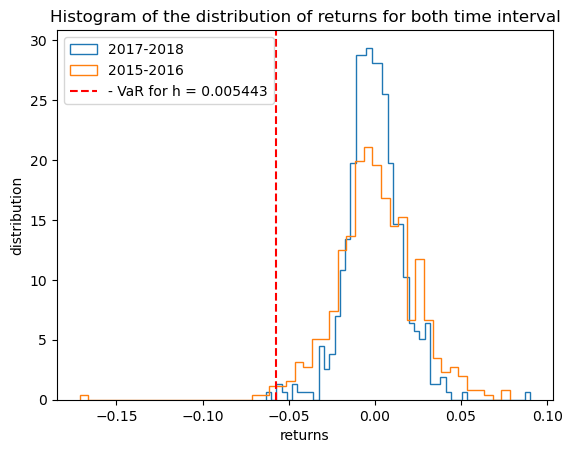

In [21]:
plt.hist(returns_2017_2018, bins=50, density=True, label="2017-2018", histtype="step", stacked=True, fill = False)
plt.hist(returns_2015_2016, bins=50, density=True, label="2015-2016", histtype="step", stacked=True, fill = False)
plt.axvline(x = - dico_var[0.005443], linestyle="--", label = "- VaR for h = 0.005443", color = "r")

plt.xlabel("returns")
plt.ylabel("distribution")
plt.title("Histogram of the distribution of returns for both time interval")
plt.legend()
plt.show()

**Observations**

This graph totally confirms our previous observations. Indeed, the 2015-2016 returns' distribution display a heavier tail and more spread distribution. So the Value at Risk calculated on the 2015-2016 dataset is based on a more spread distribution. That is why this Value at Risk overestimates the risk for the 2017-2018 dataset.

**VaR validation**

We can observe that the 2017-2018 is very narrow compared to the 2015-2016 distribution. Moreover, the size of the data is relatively small (only 510 rows). Thus the number of values that exceed the VaR is small. That could explain why for small variation of the VaR the proportion of values that exceed the VaR stay the same. Backtesting does not allow us to validate the value at risk. 

In addition, the proportion of values that exceed the VaR is approximatly 0.001961, knowing that the size of the dataset is 510, this value corresponds to 1/510. This indicates that the value at risk is exceeded exactly one time for each value at risk. We can observe that statement on the graph thanks to the VaR threshold represented by the vertical line : there is one instance that is on the left side of the VaR threshold.

## Question B (Ex2, Q5 of TD2)

**Calculate the expected shortfall for the VaR calculated in question A. How is the result, compared to the VaR?**

In [22]:
def expectedShortfall(returns_tab, VaR):
    return - np.mean([l for l in returns_tab if l <= -VaR])
es = expectedShortfall(returns_2015_2016, VaR)
print(f"for VaR ={VaR:.4f}, the expected shortfall is :{es:.4f}")

for VaR =0.0573, the expected shortfall is :0.0842


## Question C (Ex2, Q1 and Q2 of TD3)

With the dataset provided for TD1 on Natixis prices, first calculate daily returns. You will then analyse
these returns using a specific method in the field of the EVT.

**a – Estimate the GEV parameters for the two tails of the distribution of returns, using the estimator of
Pickands. What can you conclude about the nature of the extreme gains and losses?**


In [23]:
def pickandsEstimator(returns_tab):
    returns_tab.sort()
    N = len(returns_tab)
    k = np.floor(np.log(N))
    # starts from 0 so n is :
    n = N - 1 
    e = np.log((returns_tab[int(n - k + 1)] - returns_tab[int(n - 2 * k + 1)]) /
                (returns_tab[int(n - 2 * k + 1)] - returns_tab[int(n - 4 * k + 1)]))
    e /= np.log(2)
    return e


loss = list(df[df["return"] < 0]["return"] * -1)
gain = list(df[df["return"] > 0]["return"])


def naturePickands(e):
    if e > 0:
        print("Heavy tails : GEV is of Fréchet kind")
    elif e == 0:
        print("Light tails : GEV is of Gumbel kind")
    else:
        print("Bounded support : GEV is of Weibull kind")

# loss
e_loss = pickandsEstimator(loss)
print("e_loss :", e_loss)
naturePickands(e_loss)

# gain
e_gain = pickandsEstimator(gain)
print("e_gain :", e_gain)
naturePickands(e_gain)

e_loss : -0.5089715779341932
Bounded support : GEV is of Weibull kind
e_gain : 0.5772338569463368
Heavy tails : GEV is of Fréchet kind


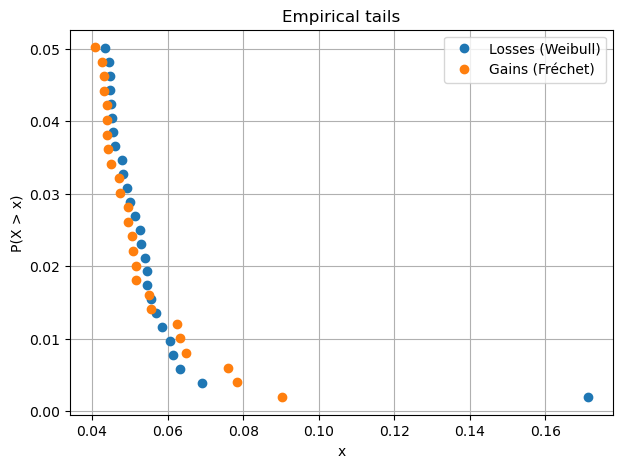

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def empirical_tail(data, label, q=0.95):
    x = np.sort(data)
    n = len(x)
    
    # on ne garde que la queue
    x_tail = x[x > np.quantile(x, q)]
    ranks = np.arange(len(x_tail), 0, -1)
    tail_prob = ranks / n
    
    plt.plot(x_tail, tail_prob, marker='o', linestyle='', label=label)

plt.figure(figsize=(7,5))
empirical_tail(loss, "Losses (Weibull)")
empirical_tail(gain, "Gains (Fréchet)")
plt.xlabel("x")
plt.ylabel("P(X > x)")
plt.legend()
plt.title("Empirical tails")
plt.grid(True, which="both")
plt.show()



**b – Calculate the value at risk based on EVT for various confidence levels, with the assumption of iid
returns.**


**Course formula**

$$
\mathrm{VaR}(p)
=
\frac{\left(\dfrac{k}{n(1-p)}\right)^{\xi^{p}} - 1}{1 - 2^{-\xi^{p}}}
\left(
X_{n-k+1:n} - X_{n-2k+1:n}
\right)
+ X_{n-k+1:n}.
$$



In [25]:
def ComputeVaRp(returns_tab, e, p):
    returns_tab.sort()
    N = len(returns_tab)
    k = np.floor(np.log(N))
    # starts from 0 so n is :
    n = N - 1 
    multi = (k / (n * (1.0 - p))) ** e - 1.0
    multi /= (1.0 - 2.0**(-e))

    return (multi * (returns_tab[int(n - k + 1)] - returns_tab[int(n - 2 * k + 1)]) 
            + returns_tab[int(n - k + 1)])

p_tab = [0.995, 0.99, 0.98, 0.95]
for p in p_tab:
    print(f"For p = {p} and the estimator = {round(e_loss, 4)}, "
          f"we have VaR(p) = {round(ComputeVaRp(loss, e_loss, p), 4)}"
)

For p = 0.995 and the estimator = -0.509, we have VaR(p) = 0.0633
For p = 0.99 and the estimator = -0.509, we have VaR(p) = 0.0596
For p = 0.98 and the estimator = -0.509, we have VaR(p) = 0.0543
For p = 0.95 and the estimator = -0.509, we have VaR(p) = 0.0436


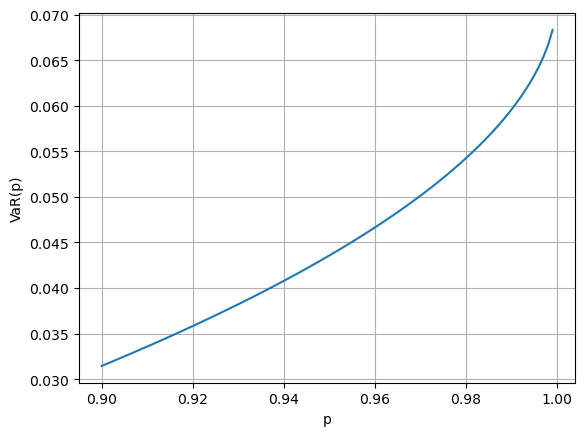

In [26]:
p_vect = np.arange(0.9, 1, 0.001)
VaR_vect = [ComputeVaRp(loss, e_loss, p) for p in p_vect]

plt.plot(p_vect, VaR_vect)
plt.xlabel("p")
plt.ylabel("VaR(p)")
plt.grid(True)
plt.show()

**Question D (Ex2, Q5 of TD4)**

With the dataset and the framework provided for TD4, estimate all the parameters of Bouchaud's price
impact model. Comment the obtained values. Is this model well specified?

In [27]:
df_TD4 = pd.read_excel("Dataset TD4.xlsx")
df_TD4 = df_TD4.rename(columns={
    "transaction date (1=1day=24 hours)": "t",
    "bid-ask spread": "spread",
    "volume of the transaction (if known)": "volume",
    "Price (before transaction)": "price"
})
df_TD4_grouped = df_TD4
df_TD4_grouped.sort_values(by = "t", inplace = True)

df_TD4_grouped["t_bin"] = (df_TD4_grouped["t"] // 0.02) * 0.02
df_TD4_grouped["t_bin"] = df_TD4_grouped["t_bin"]
df_TD4_grouped = df_TD4_grouped.groupby("t_bin").agg({
    "spread": "last", 
    "volume": "last",
    "Sign of the transaction": "last",
    "price": "last"
}).reset_index()

**Backward definition of the price: the price is the sum of past impacts (Bouchaud):**

$$p_t = p_{-\infty} + \sum_{s=-\infty}^{t-1} G(t-s)\varepsilon_s S_s V_s^r$$

where:

- $S$ is the bid-ask spread;

- $\varepsilon$ is -1 or 1 depending on whether the transaction is a buy (price = ask) or a sell (price = bid) on the market;

- $V$ is the volume of the transaction, with $r$ close to zero to have a concave function of the volume;

- $G$ is a function worth 0 on $\mathbb{R}^-$, which can be interpreted as the impact of a single order. A statistical study on long-term correlation can allow this function to be fixed, in the form, for example, of a decreasing power function.


Parameters to estimate:
- the function G
- the exposant r

### Estimation of G

For this part every elements come from 3 differents articles writed by Jean-Philippe Bouchaud. In these articles we took methods, formulas, but also exemples of estimated parameters to check the coherence of our estimations.

### References

- Bouchaud, J.-P. (2009). *Price Impact*.

- Taranto, D. E., Bormetti, G., Bouchaud, J.-P., Lillo, F., & Tóth, B. (2016).  
  *Linear models for the impact of order flow on prices*.

- Bouchaud, J.-P., Gefen, Y., Potters, M., & Wyart, M. (2004).  
  *Fluctuations and response in financial markets: the subtle*


The model from the course isn't really mentionned in the litterature or at least we don't find it, however it exist an almost similar expression in (2009, 4.3) where a non-linear modele is introduce.
$$
p_T = p_{-\infty} + \lambda \sum_{n=-\infty}^{N-1} G(N - n)\,\varepsilon_n\, v_n^{\psi}
$$
The only change is the presence of $\lambda$, which is inversely proportional to market liquidity. 
In practice, $\lambda$ implicitly captures liquidity effects such as the bid–ask spread, which is in the course formula but not explicitly included in this formula. 
This formulation can be used to estimate the impact kernel $G$ and the exponent $\psi$ (denoted $r$ in the course notation).

First from (2009), 
$$
G(\ell) = G(1) + \sum_{n=1}^{\ell} \mathcal{G}(n)
$$

where 
$$
\mathcal{G}(\ell) = -(2\rho - 1)\,G(1)\,\lambda_{\ell}
$$

p is the probability that two successive transaction have the same sign, p is usually taken between [0.6,0.7]. $\lambda_{l}$ can be obtain with another quantitie that we are able to compute,

$$
C_0(\ell) = \langle \varepsilon_{n+\ell}\varepsilon_n \rangle - \langle \varepsilon_n \rangle^2
\;\simeq\; \frac{C_0}{\ell^{\gamma}}, \qquad \text{for } \ell \gg 1
$$
$$
\log C_0(\ell) \;\simeq\; \log C_0 - \gamma \log \ell
$$

and if this approximation holds,
$$
\lambda_\ell \sim \ell^{(\gamma - 3)/2}
$$



### First Step: Estimate $\gamma$ with $C_0$

In [28]:
#Compute C_0
def C_0(eps_tab, l_min, l_max):
    
    C0 = np.zeros(l_max - l_min)
    mu = np.mean(eps_tab)
    for l in range(l_min, l_max):
        C0[l-l_min] = np.mean(eps_tab[l:]*eps_tab[:-l]) - mu**2
    return C0

l_min = 20
l_max = 50
eps = df_TD4["Sign of the transaction"].to_numpy()

C0 = C_0(eps, l_min, l_max)

mask = C0 > 0 #To be able to apply log() and find gamma
C0_reg = C0[mask] 
l_vect = np.arange(l_min, l_max)[mask]

l_vect_log = np.log(l_vect)
C0_reg_log = np.log(C0_reg)

coeffs = np.polyfit(l_vect_log, C0_reg_log, 1)
gamma_hat = -coeffs[0]
intercept = coeffs[1]
print(f"Estimated C0 = {np.exp(intercept)}")
print(f"Estimated gamma = {gamma_hat}")


Estimated C0 = 0.07464905158260028
Estimated gamma = 0.3652812433996195


##### Visualisation of the log-log relation

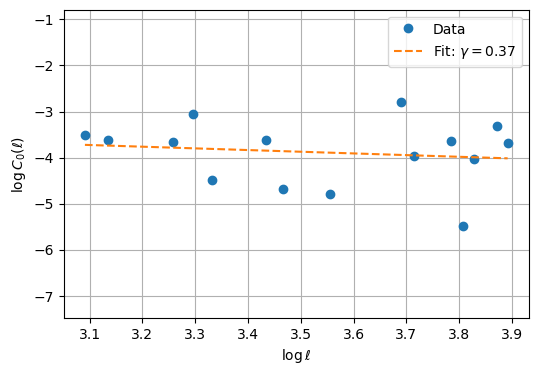

In [29]:
plt.figure(figsize=(6,4))
plt.plot(l_vect_log, C0_reg_log, 'o', label="Data")
plt.plot(l_vect_log, intercept - gamma_hat * l_vect_log, '--',
         label=rf"Fit: $\gamma={gamma_hat:.2f}$")

plt.xlabel(r"$\log \ell$")
plt.ylabel(r"$\log C_0(\ell)$")

plt.ylim(C0_reg_log.min() - 2, C0_reg_log.max() + 2)

plt.legend()
plt.grid(True)
plt.show()


##### Discussion
This estimation does not have a high level of reliability, as we only use about 1,000 observations. 
In the papers by J.-P. Bouchaud, the estimations are based on millions of data points. 
However, they typically find values of $\gamma$ between 0.2 and 0.5. 
Our estimate, $\gamma \approx 0.37$, therefore is totally realistic.

### Second Step: Determine $\lambda_l$ and Compute $G(\ell)$

We obtained $\gamma$, therefore we can easely determine $\lambda_l$ with the opproximation presented above:
$$
\lambda_\ell \sim \ell^{(\gamma - 3)/2}
$$


In [30]:
def lambda_l(gamma,l):
    lambda_l = l**((gamma-3)/2)

And thus we can also compute $\mathcal{G}(\ell)$ and so $G(\ell)$ using the formulas presented above.

In [31]:
def Gs(l, p, G1, gamma):
    lambda_l = l**((gamma-3)/2)
    Gs_l = -(2*p-1)*G1*lambda_l
    return Gs_l

def G(G1, l, p, gamma):
    G_l = G1
    i = 1
    while i <= l:
        G_l += Gs(i, p, G1, gamma)
        i+=1
    return G_l

By convention we will take $G(1)=1$ ,this choice has no impact on the shape of $G(\ell)$ and on the value of the other parameters. the choice of $\rho$ is much harder, in fact we choose the highest p such that $G(\ell)$ is well defined (such that we observe something close to a decreasing power function), we did that because when 
$$
C(\ell) \underset{\ell \gg 1}{\sim} \ell^{-\gamma},
$$
already verified. Then,
$$
\rho \to 1^{-}.
$$



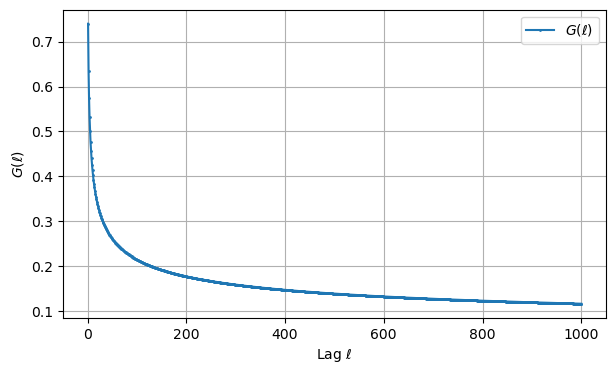

In [32]:
G1 = 1.0       
gamma = gamma_hat   
p = 0.63

L_max = 1000
lags = np.arange(1, L_max + 1)

G_vals = np.array([G(G1, l, p, gamma) for l in lags])

plt.figure(figsize=(7,4))
plt.plot(lags, G_vals, 'o-',markersize=1, label=r"$G(\ell)$")

plt.xlabel(r"Lag $\ell$")
plt.ylabel(r"$G(\ell)$")
plt.grid(True)
plt.legend()
plt.show()

### Approximate $G(\ell)$
Now that we have compute $G(\ell)$, we wan't to approximate it as a power decreasing function, how it's mentionned in the course. For that purpose we will use (2016):
$$
C(\ell) \sim \ell^{-\gamma} \;\Rightarrow\;
G(\ell) \sim \ell^{-\beta}, \qquad \beta = \frac{1 - \gamma}{2}, \quad \ell \gg 1.
$$

To obtain a more reliable estimation of $\beta$, we will estimate it in two different ways.
- First, by determining the slope of the log–log plot of $G(\ell)$ as a function of $\ell$ (for large $\ell$ ).
- Second, using the approximation $\beta = \frac{1 - \gamma}{2}$, which requires a Hurst exponent $H$ close to 0.5, a condition that we will verify.



#### Determining the slope of the log–log plot of $G(\ell)$ as a function of $\ell$

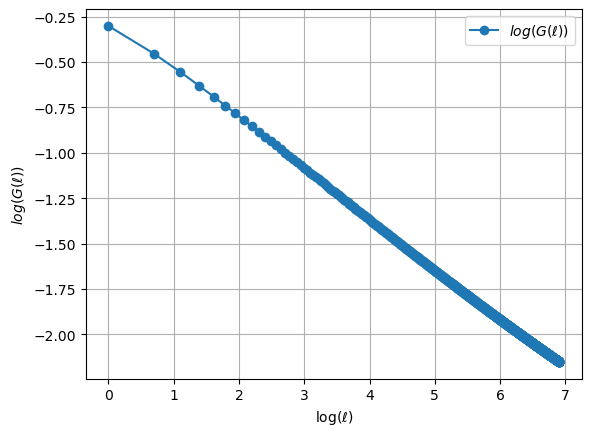

In [33]:
log_lags = np.log(lags)
log_G_vals = np.log(G_vals)

plt.plot(log_lags, log_G_vals, 'o-', label=r"$log(G(\ell))$")


plt.xlabel(r"log($\ell$)")
plt.ylabel(r"$log(G(\ell))$")
plt.grid(True, which="both")
plt.legend()
plt.show()

In [34]:
l_min = 100
mask = lags >= l_min

lags_filtered = lags[mask]
G_filtered = np.abs(G_vals[mask])

log_l = np.log(lags_filtered)
log_G = np.log(G_filtered)

coeffs = np.polyfit(log_l, log_G, 1)
intercept = coeffs[1]
beta_hat = -coeffs[0]

print(f"Estimated beta = {beta_hat:.3f}")


Estimated beta = 0.264


We find a $\beta$ of 0.264, we will visualize this relation.

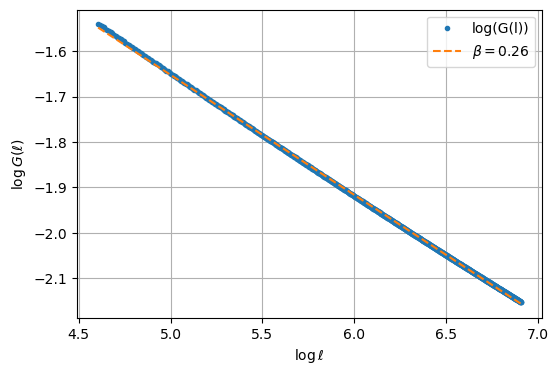

In [35]:
plt.figure(figsize=(6,4))
plt.plot(log_l, log_G, 'o',markersize=3, label="log(G(l))")
plt.plot(log_l, intercept - beta_hat * log_l, '--',
         label=rf"$\beta={beta_hat:.2f}$")
plt.xlabel(r"$\log \ell$")
plt.ylabel(r"$\log G(\ell)$")
plt.legend()
plt.grid(True)
plt.show()

We can see on this visualisation that the relation on the log-log plot is indeed very linear.

#### Using now the approximation $\beta = \frac{1 - \gamma}{2}$

This approximation from 2016 is derived from the original relation (2004):
$$
2H = 2 - 2\beta - \gamma
$$
where H is the Hurst exponent.

Therefore a condition (fluctuations are diffusive at long times (H = 1/2)), give us $\beta = \frac{1 - \gamma}{2}$. We will estimate the Hurst exponent to see if the condition is respected.


In [36]:
#Use of df_TD4_grouped to have constant duration for the increments
M2 = ((df_TD4_grouped["price"]- df_TD4_grouped["price"].shift(1)) * 
      (df_TD4_grouped["price"] - df_TD4_grouped["price"].shift(1))).mean()
def ComputeM2_prime(df):
    m2_prime = 0.0

    for i in range (1, (len(df)-1) // 2 + 1):
        m2_prime += ((df["price"].iloc[2*i] - df["price"].iloc[2*i-2]) * 
                     (df["price"].iloc[2*i] - df["price"].iloc[2*i-2]))
    m2_prime /= (len(df)-1) // 2
    
    return m2_prime

M2_prime = ComputeM2_prime(df_TD4_grouped)
H_hat = np.log2(M2_prime/M2)/ 2
H_hat

0.5451525909483125

The H estimate is pretty close to 0.5 so we can use the relation $\beta = \frac{1 - \gamma}{2}$ but also the non simplified one, with the H estimated.

In [37]:
beta_hat2 = (1-gamma_hat)/2
print(beta_hat2)

beta_hat3 = (2 - 2*H_hat - gamma_hat)/2
print(beta_hat3)

0.31735937830019023
0.27220678735187775


These values are very close to the estimate of $\beta$ obtained with the first method. 
Therefore, for large $\ell$, we can approximate
$$
G(\ell) \sim \ell^{-\beta},
$$
with $\beta \approx 0.27$.


### Estimation of r
In order to estimate the model, we first express the price as follows:
$$
p_t = p_0 + \sum_{s=0}^{t-1} G(t-s)\,\varepsilon_s\, S_s\, V_s^{\,r}.
$$

In other words, the price at time \(t\) is equal to the price at the beginning of the period plus the cumulative impact of all trades since the beginning of the period.

We take:
- $p_0$ as the first observed price;
- $G(\ell)$ as estimated above;
- for the unknown volumes in our dataset, we use the mean volume. This approach is not perfect but remains coherent, since some papers by Bouchaud and co-authors consider constant volumes for their estimations.




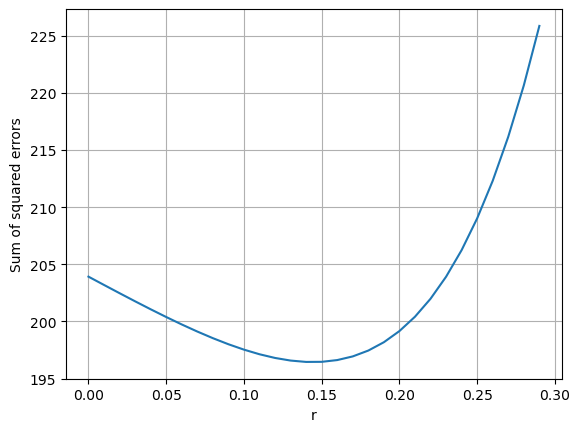

In [38]:
df_TD4["volume"] = df_TD4["volume"].fillna(df_TD4["volume"].mean())

def p_t(p_0, G_vect, eps_vect, S_vect, V_vect, r, t):
    return p_0 + (G_vect[:t] * eps_vect[:t] * S_vect[:t] * (V_vect[:t]**r)).sum()


p_0 = df_TD4["price"].iloc[0]
p_t_true = df_TD4["price"].values
G_vect = G_vals[::-1]
S_vect = df_TD4["spread"].iloc[:-1]
V_vect = df_TD4["volume"].iloc[:-1]
eps_vect = eps[:-1]


T = len(S_vect)
r_test = np.arange(0, 0.3, 0.01)
SE_test = []

for r in r_test:
    se_r = 0.0
    for t in range(1, T):
        p_model = p_t(p_0, G_vect, eps_vect, S_vect, V_vect, r, t)
        se_r += (p_model - p_t_true[t])**2
    SE_test.append(se_r)

SE_test = np.array(SE_test)
plt.plot(r_test, SE_test)
plt.xlabel("r")
plt.ylabel("Sum of squared errors")
plt.grid(True)

### Discussion

We find that the difference between the true price and the price obtained as the sum of impacts is minimized for $r \approx 0.14$. This value is consistent with the existing literature: for instance, in Bouchaud et al. (2009), values of $r$ close to 0.1-0.3 are reported. However, this estimation relies on the assumption that the impact of transactions occurring before $t_0$ can be neglected. 


### Conclusion and discussion about the specification of the model

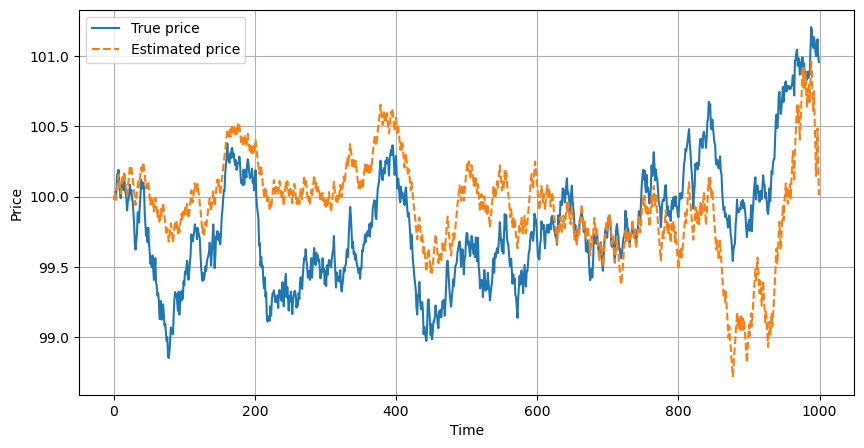

In [39]:
t_vect = np.arange(1, T)
p_t_hat = []
for t in range(1, T):
    p_model = p_t(p_0, G_vect, eps_vect, S_vect, V_vect, r, t)
    p_t_hat.append(p_model)

p_t_hat = np.array(p_t_hat)
p_t_true_plot = df_TD4["price"].values[1:T]

plt.figure(figsize=(10, 5))
plt.plot(t_vect, p_t_true_plot, label="True price")
plt.plot(t_vect, p_t_hat, label="Estimated price", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()



## Question E

In [40]:
df = pd.read_excel("Dataset TD5.xlsx", header=None)

In [41]:
df_gbp = df[[0, 1, 2]]
df_sek = df[[4, 5, 6]]
df_cad = df[[8, 9, 10]]

def prepareDataset(df):
    # Shape the dataset
    df = df.drop([0, 1, 2]).reset_index(drop=True)

    df.columns = ["DATE", "HIGH", "LOW"]

    # Transform the data based on the columns' type
    df["HIGH"] = pd.to_numeric(df["HIGH"])
    df["LOW"] = pd.to_numeric(df["LOW"])
    df["DATE"] = pd.to_datetime(df["DATE"])

    return df
    
df_gbp = prepareDataset(df_gbp)
df_sek = prepareDataset(df_sek)
df_cad = prepareDataset(df_cad)

In [42]:
df_gbp

,DATE,HIGH,LOW
0,2016-03-07 08:59:59.990,1.2932,1.2917
1,2016-03-07 09:15:00.000,1.2940,1.2930
2,2016-03-07 09:30:00.000,1.2943,1.2922
3,2016-03-07 09:45:00.000,1.2930,1.2913
4,2016-03-07 10:00:00.000,1.2931,1.2921
...,...,...,...
12924,2016-09-07 17:00:00.000,1.1879,1.1867
12925,2016-09-07 17:15:00.000,1.1883,1.1874
12926,2016-09-07 17:30:00.000,1.1880,1.1874
12927,2016-09-07 17:45:00.000,1.1874,1.1866


**a – With Haar wavelets and the dataset provided with TD5, determine the multiresolution correlation between all the pairs of FX rates, using GBPEUR, SEKEUR, and CADEUR (work with the average between the highest and the lowest price and transform this average price in returns on the smallest time step). Do you observe an Epps effect and how could you explain this?**

In [43]:
def computeMean(df):
    df["mean"] = (df.iloc[:,1] + df.iloc[:,2])/2

def ComputeReturn(df):
    df["return"] = df["mean"] / df["mean"].shift(1) - 1
    df.dropna(inplace = True)

In [44]:
computeMean(df_cad)
computeMean(df_gbp)
computeMean(df_sek)

df_cad_mean = df_cad.copy()
df_gbp_mean = df_gbp.copy()
df_sek_mean = df_sek.copy()

ComputeReturn(df_cad)
ComputeReturn(df_gbp)
ComputeReturn(df_sek)

In [45]:
# Mother wavelet
def Wavelet_Haar(t):
    return np.where((0 <= t) & (t < 0.5), 1,
        np.where((0.5 <= t) & (t < 1), -1,
                 0)) 

# Daughter wavelet
def daughter_wavelet(j, k, t):
    return 2**(j/2) * Wavelet_Haar(t * 2**j - k)

# Wavelet transform
# z is the signal => price
def z_empirical(df, j, k, tau):
    t = np.arange(len(df)) * tau
    return np.sum(df["mean"] * daughter_wavelet(j, k, t) * tau)

# x[start : stop : step]
def Scale_coefficient(df):
    C = df["return"].to_numpy()

    scale_total = [C]
    while len(C) >= 2:
        if len(C) % 2 == 1:
            C = C[:-1]
        C = (C[0::2] + C[1::2]) / np.sqrt(2)
        scale_total.append(C)
    return scale_total

C_gbp = Scale_coefficient(df_gbp)
C_sek = Scale_coefficient(df_sek)
C_cad = Scale_coefficient(df_cad)

C:\Users\natga\AppData\Local\Temp\ipykernel_13800\984850514.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return cov / np.sqrt(var1 * var2)


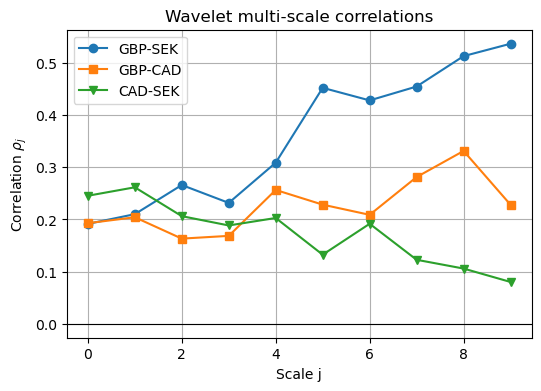

In [46]:
def covariance1D(c1, c2):
    return np.mean((c1 - np.mean(c1)) * (c2 - np.mean(c2)))

def correlation1D(c1, c2):
    n = min(len(c1), len(c2))
    c1 = c1[:n]
    c2 = c2[:n]

    cov = covariance1D(c1, c2)
    var1 = np.mean((c1 - np.mean(c1))**2)
    var2 = np.mean((c2 - np.mean(c2))**2)

    return cov / np.sqrt(var1 * var2)

def correlationMultiScale(C1, C2):
    n = min(len(C1), len(C2))
    rho = []

    for j in range(n):
        rho.append(correlation1D(C1[j], C2[j]))

    return np.array(rho)

rho_gbp_sek = correlationMultiScale(C_gbp, C_sek)
rho_gbp_cad = correlationMultiScale(C_gbp, C_cad)
rho_cad_sek = correlationMultiScale(C_cad, C_sek)

#Parceque pour les J trop important il y a pas assez d'élément ça diverge
valid_j_gbp = [j for j in range(len(C_gbp)) if len(C_gbp[j]) >= 20]
valid_j_cad = [j for j in range(len(C_cad)) if len(C_cad[j]) >= 20]
valid_j_sek = [j for j in range(len(C_sek)) if len(C_sek[j]) >= 20]

valid_j = list(set(valid_j_gbp) & set(valid_j_cad) & set(valid_j_sek))

rho_gbp_sek = rho_gbp_sek[valid_j]
rho_gbp_cad = rho_gbp_cad[valid_j]
rho_cad_sek = rho_cad_sek[valid_j]


plt.figure(figsize=(6,4))
plt.plot(rho_gbp_sek, 'o-', label="GBP-SEK")
plt.plot(rho_cad_sek, 's-', label="GBP-CAD")
plt.plot(rho_gbp_cad, 'v-', label="CAD-SEK")

plt.axhline(0, color='k', lw=0.8)
plt.xlabel("Scale j")
plt.ylabel(r"Correlation $\rho_j$")
plt.title("Wavelet multi-scale correlations")
plt.grid(True)
plt.legend()
plt.show()

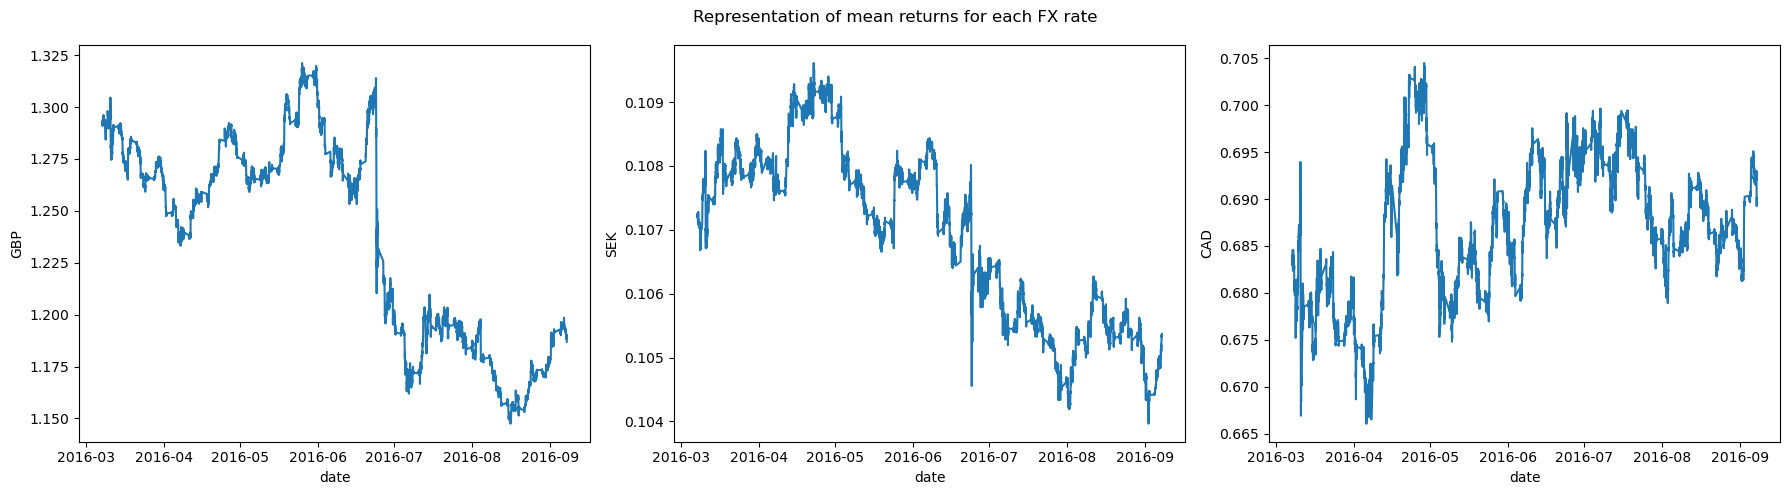

In [47]:
fx_rates = [df_gbp, df_sek, df_cad]
names = ["GBP", "SEK", "CAD"]
fig, axes = plt.subplots(1, 3, figsize= (18, 5))

for i in range(len(fx_rates)):
    axes[i].plot(fx_rates[i]["DATE"], fx_rates[i]["mean"])
    axes[i].set_xlabel("date")
    axes[i].set_ylabel(names[i])

fig.suptitle("Representation of mean returns for each FX rate")
plt.tight_layout()
plt.show()

**b – Calculate the Hurst exponent of GBPEUR, SEKEUR, and CADEUR. Determine their annualized volatility using the daily volatility and Hurst exponents.**

In [48]:
def ComputeM2(df):
    return ((df["mean"]- df["mean"].shift(1)) * (df["mean"] - df["mean"].shift(1) )).mean()

def ComputeM2_prime(df):
    m2_prime = 0.0
        
    for i in range (1, (len(df)-1) // 2 + 1):
        m2_prime += (df["mean"].iloc[2*i] - df["mean"].iloc[2*i-2]) * (df["mean"].iloc[2*i] - df["mean"].iloc[2*i-2])
    m2_prime /= (len(df)-1) // 2
    
    return m2_prime

def ComputeH_hat(df):
    computeMean(df)
    m2_prime = ComputeM2_prime(df)
    m2 = ComputeM2(df)
    return np.log2(m2_prime/m2) / 2

print("Hurst exponent for GBPEUR :", ComputeH_hat(df_gbp_mean))
print("Hurst exponent for SEKEUR :", ComputeH_hat(df_sek_mean))
print("Hurst exponent for CADEUR :", ComputeH_hat(df_cad_mean))

Hurst exponent for GBPEUR : 0.6714143303551521
Hurst exponent for SEKEUR : 0.6545913434209916
Hurst exponent for CADEUR : 0.6552439913405917


In [49]:
def ComputeVolAnnualised(df):
    H = ComputeH_hat(df)
    ComputeReturn(df)
    return np.std(df["return"], ddof=1) * ((252*96)**H)

print("Annualised Volatility GBP :", ComputeVolAnnualised(df_gbp_mean))
print("Annualised Volatility SEK :", ComputeVolAnnualised(df_sek_mean))
print("Annualised Volatility CAD :", ComputeVolAnnualised(df_cad_mean))

Annualised Volatility GBP : 0.546938318760874
Annualised Volatility SEK : 0.24223410463728343
Annualised Volatility CAD : 0.37736743674564216
